# When in doubt use random forest

## Introduction to random forests

A random forest **is a supervised machine learning algorithm based on ensemble learning**. It is <span  <span style="color: green;">used for both regression and classification problems</span>. The general idea behind random forests is to <span  <span style="color: green;">build multiple decision trees and aggregate them to get an accurate result. **A decision tree is a deterministic algorithm, which means if the same data is given to it, the same tree will be produced each time**</span>. **They have a tendency to overfit, because they build the best tree possible with the given data, but may fail to generalize when unseen data is provided**. **All the decision trees that make up a random forest are different because we build each tree on a different random subset of our data. A random forest tends to be more accurate than a single decision tree because it minimizes overfitting.**

The following diagram demonstrates bootstrap sampling being done from the source sample. Models are built on each of the samples and then the predictions are combined to arrive at a final result:

![Random forest demonstration](intro_random_forest.png)

> Each tree in a random forest is built using the following steps where A represents the entire forest, a represents a single tree, for $a = 1 \text{ to } A$:

1. Create a bootstrap sample with replacement, $D$ training from $x, y$ label these $X_a, y_a$
2. Train the tree $f_a$ on $X_a, y_a$
3. Average the predictions or take the majority vote to arrive at a final prediction

In a regression problem, predictions for the test instances are made by taking the mean of the predictions made by all trees. This can be represented as follows:

$$\hat{y} = \frac{1}{A} \sum_{a=1}^{A} f_a(x)$$

Here, $N$ is the total number of trees in the random forest. $a=1$ represents the first tree in a forest, while the last tree in the forest is $A$. $f_a(x)$ represents the prediction from a single tree.

**If we have a classification problem, majority voting or the most common answer is used**.

## Implementing a random forest for predicting credit card defaults using Scikit-learn

The scikit-learn library implements random forests by providing two estimators: `RandomForestClassifier` and `RandomForestRegressor`. They take various parameters, some of which are explained as follows:

* `n_estimators`: This parameter is the number of trees the algorithm builds before taking a maximum vote or the average prediction. In general, the higher the number of trees the better the performance and the accuracy of the predictions, but it also costs more in terms of computation.
* `max_features`: This parameter is the maximum number of features that the random forest is allowed to try in an individual tree.
* `min_samples_leaf`: This parameter determines the minimum number of leaves that are required to split an internal node.
* `n_jobs`: This hyperparameter tells the engine how many jobs to run in parallel for both fitting the model and predicting new instances. If it has a value of None or 1, it runs only one job. A value of $-1$ means it will use all the processors.
* `random_state`: This parameter will always produce the same results when it has a definite value of `random_state` and if it has been given the same hyperparameters and the same training data.
* `oob_score`: This parameter is also known as **out-of-the-bag** sampling, and is a random forest cross-validation method. In this sampling method, about one-third of the data is not used to train the model and can be used to evaluate its performance. These samples are called the **out-of-the-bag** samples.

### Getting ready

In this example, we use a dataset from the UCI ML repository on credit card defaults. This dataset contains the following information:

* Default payments
* Demographic factors
* Credit data
* History of payments
* Bill statements of credit card clients

The data and the data descriptions are provided in the GitHub folder:

We will start by loading the required libraries and reading our dataset:

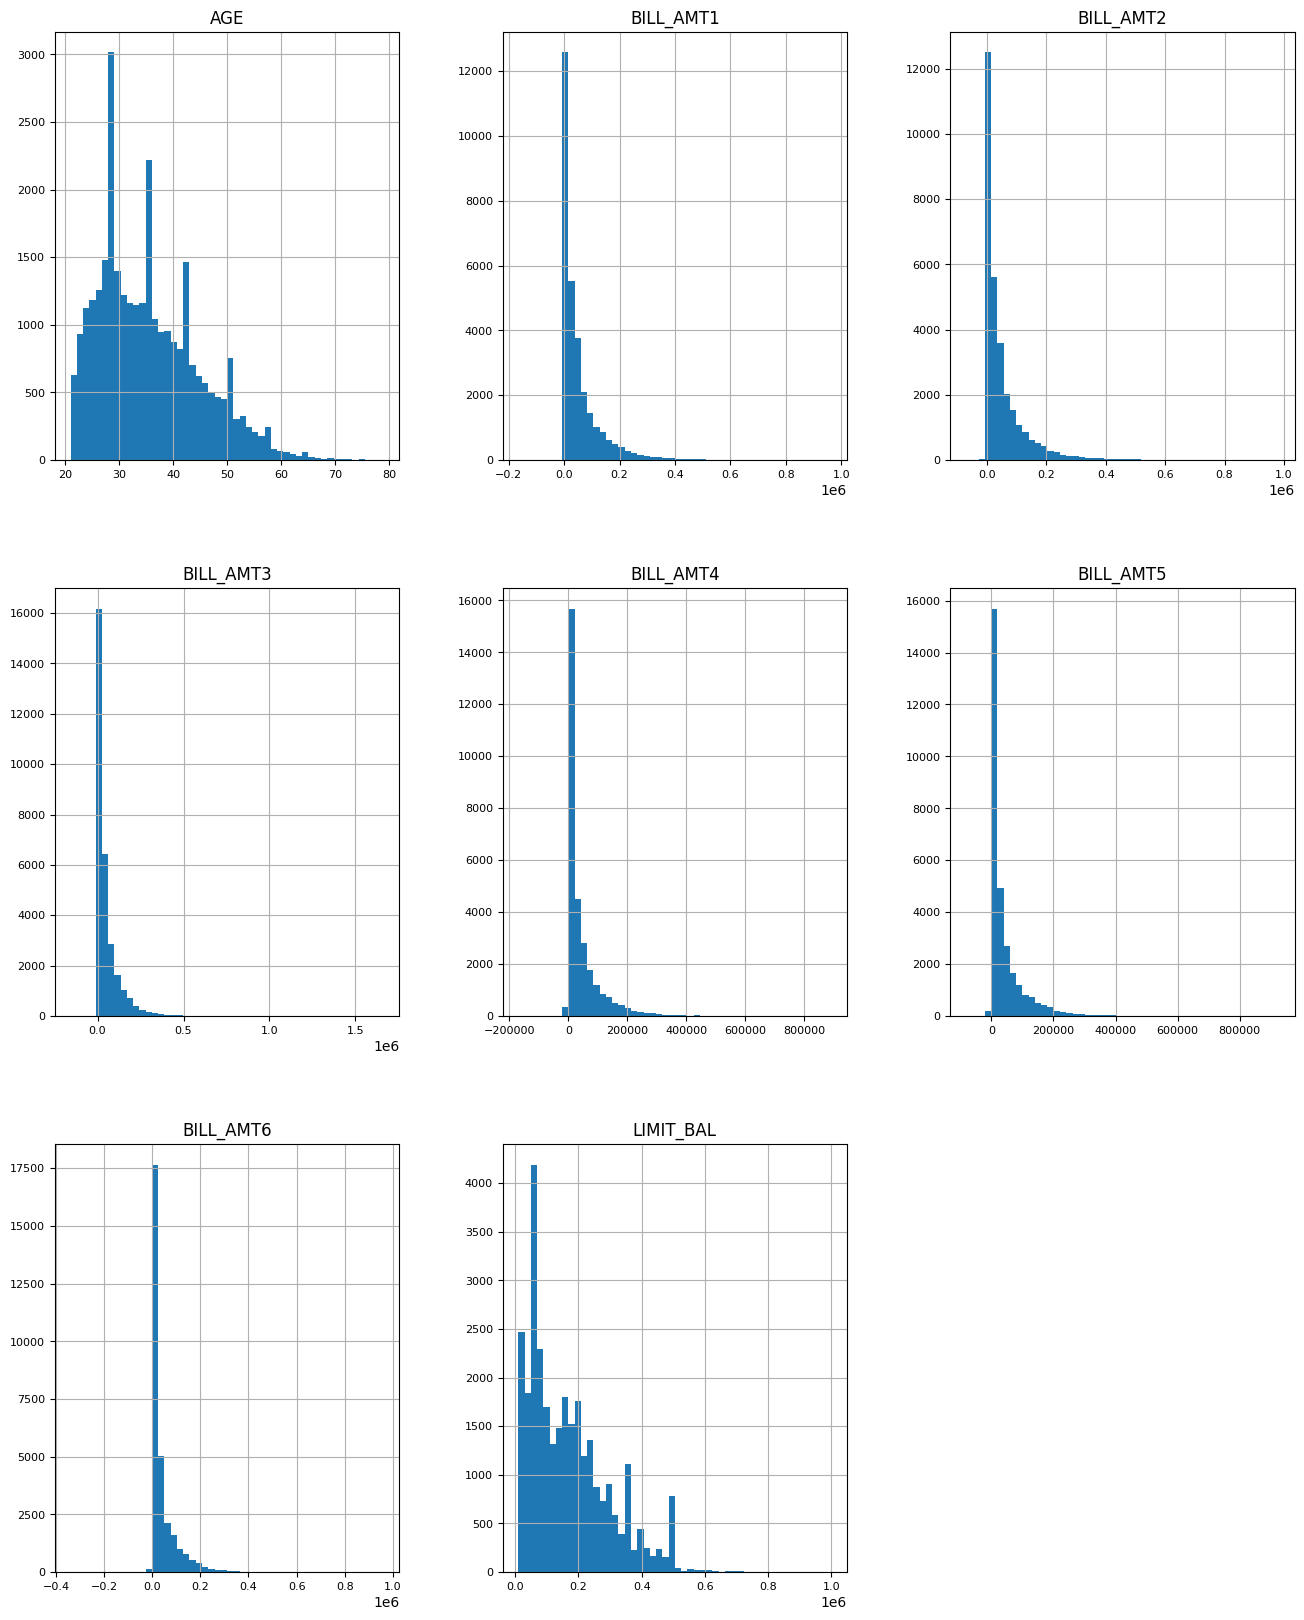

In [12]:
# We will start by loading the required libraries and reading our dataset:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Let's now read our data. We will prefix the DataFrame name with df_ so that we can understand it easily:
df_creditcarddata = pd.read_csv("UCI_Credit_Card.csv")
# We check the shape of the dataset:
df_creditcarddata.shape
# We check the datatypes:
df_creditcarddata.dtypes
# We drop the ID column, as this is not required:
df_creditcarddata = df_creditcarddata.drop("ID", axis= 1) 

# We can explore our data in various ways. Let's take a look at a couple of different methods:
selected_columns = df_creditcarddata[['AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6', 'LIMIT_BAL']]

selected_columns.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
# Note: that we have used a semicolon in the last line in the preceding code block. The semicolon helps to hide the verbose
# information produced by Matplotlib. xlabelsize and ylabelsize are used to adjust the font size in the x-axis and the y-axis.

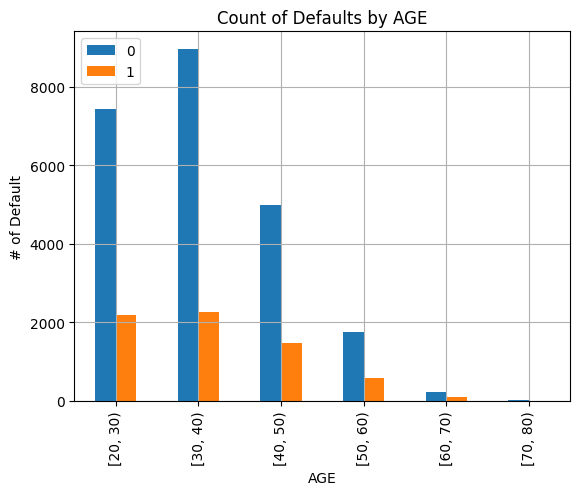

In [13]:
# We will now explore the payment defaults by age group. We bucket the age variable and store the binned values in a new variable, age_group, in df_creditcarddata:

df_creditcarddata['age_group'] = pd.cut(df_creditcarddata['AGE'], range(0, 100, 10), right=False)
df_creditcarddata.head()

# We then use our new age_group variable to plot the number of defaults per age group:

# Default vs Age
pd.crosstab(df_creditcarddata.age_group, df_creditcarddata["default.payment.next.month"]).plot(kind='bar',stacked=False, grid=True)

plt.title('Count of Defaults by AGE')
plt.xlabel('AGE')
plt.ylabel('# of Default')
plt.legend(loc='upper left')
# The following screenshot shows the amount of defaults per age:

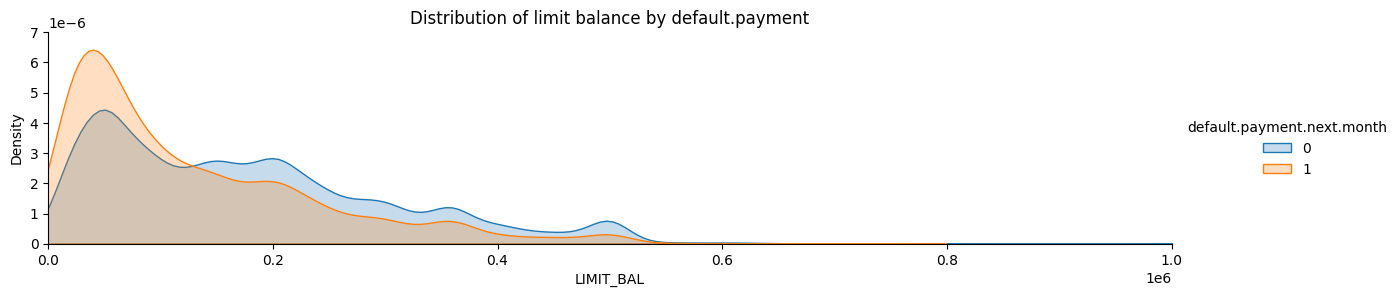

In [14]:
# We can drop the age_group variable from df_creditcarddata since we do not need it anymore:

df_creditcarddata = df_creditcarddata.drop(columns = ['age_group'])
df_creditcarddata.head()
# We will now look at the payment defaults according to the credit limits of the account holders:

fig_facetgrid = sns.FacetGrid(df_creditcarddata, hue='default.payment.next.month', aspect=4)
fig_facetgrid.map(sns.kdeplot, 'LIMIT_BAL', fill=True)
max_limit_bal = df_creditcarddata['LIMIT_BAL'].max()
fig_facetgrid.set(xlim=(0,max_limit_bal));
fig_facetgrid.set(ylim=(0.0,0.000007));
fig_facetgrid.set(title='Distribution of limit balance by default.payment')
fig_facetgrid.add_legend()
# The preceding code gives us the following plot:

In [15]:
# We can also assign labels to some of our variables to make the interpretations better. We assign labels for the
# Gender, Marriage, and Education variables.

# We also change the datatype of the pay variables to the string:

GenderMap = {2:'female', 1:'male'}
MarriageMap = {1:'married', 2:'single', 3:'other', 0: 'other'}
EducationMap = {1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'unknown', 6:'unknown', 0:'unknown'}

df_creditcarddata['SEX'] = df_creditcarddata.SEX.map(GenderMap)
df_creditcarddata['MARRIAGE'] = df_creditcarddata.MARRIAGE.map(MarriageMap) 
df_creditcarddata['EDUCATION'] = df_creditcarddata.EDUCATION.map(EducationMap)
df_creditcarddata['PAY_0'] = df_creditcarddata['PAY_0'].astype(str) 
df_creditcarddata['PAY_2'] = df_creditcarddata['PAY_2'].astype(str) 
df_creditcarddata['PAY_3'] = df_creditcarddata['PAY_3'].astype(str) 
df_creditcarddata['PAY_4'] = df_creditcarddata['PAY_4'].astype(str) 
df_creditcarddata['PAY_5'] = df_creditcarddata['PAY_5'].astype(str) 
df_creditcarddata['PAY_6'] = df_creditcarddata['PAY_6'].astype(str) 
# There are more explorations available in the code bundle provided with this book. We now move on to training our random forest model.

### How to do it

We will now look at how to use a random forest to train our model:

x_train (21000, 79)
x_test (9000, 79)
y_train (21000, 1)
y_test (9000, 1)
81.13 %


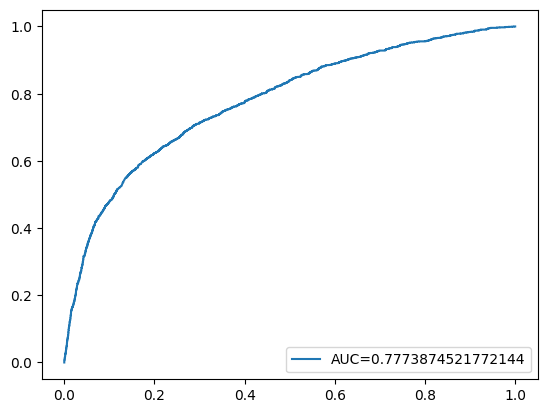

In [16]:
# 1 We start by splitting our target and feature variables:
predictor = df_creditcarddata.iloc[:, df_creditcarddata.columns != 'default.payment.next.month']
target = df_creditcarddata.iloc[:, df_creditcarddata.columns == 'default.payment.next.month']

# 2 We separate the numerical and non-numerical variables in our feature set:
# Save all categorical columns in list
categorical_columns = [col for col in predictor.columns.values if predictor[col].dtype == 'object']
# Dataframe with categorical features
df_categorical = predictor[categorical_columns]
# Dataframe with numerical features
df_numeric = predictor.drop(categorical_columns, axis=1)

# 3 We dummy code the categorical variables:
dummy_code_cat_vars = pd.get_dummies(df_categorical, drop_first=True)

# 4 We concatenate the dummy code variables to our DataFrame:
df_predictor = pd.concat([df_numeric, dummy_code_cat_vars], axis=1)
# Drop the 'agegroup' column if it exists (it is of type category/interval and not suitable for modeling)
if 'agegroup' in df_predictor.columns:
    df_predictor = df_predictor.drop(columns=['agegroup'])

# 5 We split our dataset into training and testing subsets:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_predictor, target, test_size=0.30, random_state=0)
print("x_train", X_train.shape)
print("x_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

# 6 We scale the features with StandardScaler():
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7 We might notice that the column names have been changed to numbers. We assign the columns names
# and index values back to the scaled DataFrame:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_train = X_train_scaled
X_test = X_test_scaled

# Convert y_train to a 1D array
y_train = y_train.values.ravel()

# 8 We import RandomForestClassifier() from sklearn.ensemble. We will then build our random forest classifier model:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=0, n_estimators=100,
                                   criterion='entropy', max_leaf_nodes=20, oob_score=True, n_jobs=-1)
# Fit the model
model_RF = classifier.fit(X_train, y_train)

# 9 After that, we calculate the accuracy of our training model:
acc_random_forest = round(classifier.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest, 2), "%")

# 10 We get the false positive rate (FPR) and true positive rate (TPR) by passing y_test and y_pred_proba to roc_curve(). We also get the auc value using roc_auc_score(). Using the FPR, TPR, and the AUC value, we plot the ROC curve with the AUC value annotated on the plot:
from sklearn import metrics
y_pred_proba = model_RF.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.legend(loc=4)
plt.show()
# The following graph shows the ROC curve with the AUC value annotated on it:

In [17]:
# 11 We can also evaluate other scores, as shown here:
# predict the model
y_pred_RF = model_RF.predict(X_test)

# evaluate other scores
evaluation_scores = pd.Series({'Model': " Random Forest Classifier ",
                                'ROC Score' : metrics.roc_auc_score(y_test, y_pred_RF),
                                'Precision Score': metrics.precision_score(y_test, y_pred_RF),
                                'Recall Score': metrics.recall_score(y_test, y_pred_RF),
                                'Accuracy Score': metrics.accuracy_score(y_test, y_pred_RF),
                                'Kappa Score':metrics.cohen_kappa_score(y_test, y_pred_RF)})

print(evaluation_scores)
# The preceding code produces the following evaluation scores:

Model               Random Forest Classifier 
ROC Score                             0.60721
Precision Score                      0.673212
Recall Score                         0.247423
Accuracy Score                       0.811889
Kappa Score                          0.278229
dtype: object


In [18]:
# 12 We can also evaluate a few statistics based on the class of the target variable, which in this case is 0 or 1:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_RF))
# classification_report from sklearn.metrics gives us the following scores based on each class of the target variable:

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7060
           1       0.67      0.25      0.36      1940

    accuracy                           0.81      9000
   macro avg       0.75      0.61      0.63      9000
weighted avg       0.79      0.81      0.78      9000



Text(0, 0.5, 'Variables')

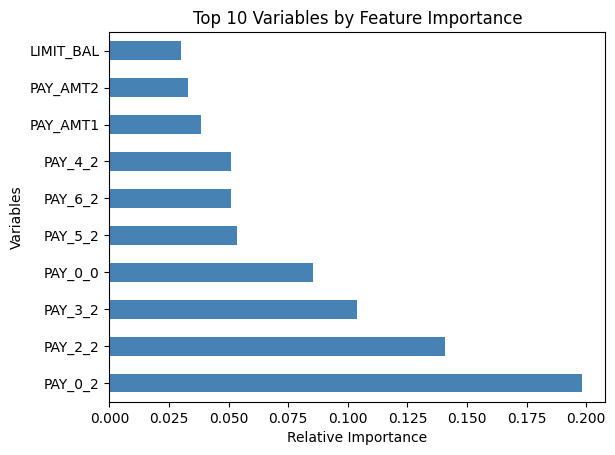

In [19]:
# 13 We can plot the top 10 variables by feature importance to see which variables are important for the model:
feature_importances = pd.Series(classifier.feature_importances_, index=X_train.columns)
# plot with different colors
feature_importances.nlargest(10).plot(kind='barh', color='steelblue')
plt.title('Top 10 Variables by Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Variables')
# The following screenshot shows the top 10 variables with their relative importance:

### How it works

In Step 1, we split our target and feature variables. In Step 2, in our feature set, we separated the numeric and non-numeric variables. In Step 3 and Step 4, we converted the non-numeric variables to dummy coded variables and added them back to the DataFrame. In Step 5, we split our dataset into training and testing subsets, and in Step 6, we imported `StandardScaler()` from sklearn.preprocessing and applied the same scale to our features.

After executing the commands in Step 6, we noticed that the column names had changed to sequential numbers. For this reason, in Step 7, we assigned the column names and the index values back to the scaled DataFrame. In Step 8, we imported `RandomForestClassifier()` from sklearn.ensemble and built our first random forest classifier model. After that, in Step 9 and Step 10, we used our model to calculate the accuracy of our training model and plotted the ROC curve respectively. We also annotated the ROC Curve with the AUC value.

In Step 11, we evaluated other scores, including the **kappa value, the precision, the recall, and the accuracy**.

In Step 12, we also evaluated these scores based on each class of the target variable, which in this case is $0$ or $1$, using `classification_report` from sklearn.metrics. There, `classification_report()` provides us with metrics such as **precision, recall, and f1-score** by each class, as well as the average of each of the metrics.

`classification_report()` reports averages, including averaging the total **true positives, false negatives and false positives**, averaging the **unweighted mean per label, and averaging the support-weighted mean per label**. It also reports sample averages for multi-label classification.

Finally, in Step 13, we looked at the relative variable importance of the top 10 features. This can help in feature selection to build the models with the right features.

> There are various feature selection methods available, such as averaged variable, importance, Boruta, recursive feature selection, and variable selection using RF.

### There's more

<span style="color: green;">Isolation forest</span> is another algorithm that is built on the basis of decision trees, and **it's used for anomaly and outlier detection. This algorithm is based on the assumption that the outlier data points are rare**.

The algorithm works a bit differently to the random forest. **It creates a bunch of decision trees, then it calculates the path length necessary to isolate an observation in the tree. The idea is that isolated observations, or anomalies, are easier to separate because there are fewer conditions necessary to distinguish them from normal cases. Thus, the anomalies will have shorter paths than normal observations and will, therefore, reside closer to the root of the tree**. When several decision trees are created, the scores are averaged, which gives us a good idea about which observations are truly anomalies. As a result, isolation forests are used for outliers and anomaly detection.

Also, an isolation forest does not utilize any distance or density measures to detect an anomaly. This reduces the computational cost significantly compared to the distance-based and density-based methods.

In scikit-learn, `sklearn.ensemble.IsolationForest` provides an implementation of the isolation forest algorithm.

### Implementing random forest for predicting credit card defaults using H2O

H2O is an open source and distributed machine learning platform that allows you to build machine learning models on large datasets. H2O supports both supervised and unsupervised algorithms and is extremely fast, scalable, and easy to implement. H2O's REST API allows us to access all its functionalities from external programs such as R and Python. H2O in Python is designed to be very similar to scikit-learn. At the time of writing this book, the latest version of H2O is H2O v3.

The reason why H2O brought lightning-fast machine learning to enterprises is given by the following explanation:

> "H2O's core code is written in Java. Inside H2O, a distributed key/value store is used to access and reference data, models, objects, and so on, across all nodes and machines. The algorithms are implemented on top of H2O's distributed Map/Reduce framework and utilize the Java fork/join framework for multi-threading. The data is read in parallel and is distributed across the cluster and stored in memory in a columnar format in a compressed way. H2O's data parser has built-in intelligence to guess the schema of the incoming dataset and supports data ingest from multiple sources in various formats"
> from h2o.ai

H2O provides us with distributed random forests, which are a powerful tool used for classification and regression tasks. This generates multiple trees, rather than single trees. In a distributed random forest, we use the average predictions of both the classification and regression models to reach a final result.

### Getting ready

Java is an absolute must for H2O to run. Make sure you have Java installed with the following command in Jupyter:

```bash
! apt-get install default-jre
! java -version
```

You will now need to install H2O. To install this from Jupyter, use the following command:

In [20]:
!poetry add h2o

The following packages are already present in the pyproject.toml and will be skipped:

  - h2o

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [21]:
# Import the required libraries:

import h2o
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn import metrics
# To use H2O, we need to initialize an instance and connect to it. We can do that as follows:

In [22]:
h2o.connect(url="http://127.0.0.1:54321", port=54321, https=False, verbose=True)
# By default, the preceding command tries to connect to an instance. If it fails to do so, it
# will attempt to start an instance and then connect to it. Once connected to an instance,
# we will see the details of that instance, as follows:

Connecting to H2O server at http://127.0.0.1:54321 ...

 successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,2 mins 15 secs
H2O_cluster_timezone:,Atlantic/Reykjavik
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 11 days
H2O_cluster_name:,H2O_from_python_ibrahim_585ja7
H2O_cluster_total_nodes:,2
H2O_cluster_free_memory:,3.757 Gb
H2O_cluster_total_cores:,24
H2O_cluster_allowed_cores:,24
H2O_cluster_status:,"locked, healthy"


<H2OConnection to http://127.0.0.1:54321, no session>

In [ ]:
# We read our data into a pandas DataFrame:

df_creditcarddata = pd.read_csv("./UCI_Credit_Card.csv")
# We change our pandas DataFrame to an H2O DataFrame using h2o.H2OFrame(). We name the df_creditcarddata H2O DataFrame:
print(df_creditcarddata.shape)
hf_creditcarddata = h2o.H2OFrame(df_creditcarddata)
# Check whether the data in the H2O DataFrame is properly loaded as follows:

hf_creditcarddata.head()
# We can see the summary statistics with the describe() method:

hf_creditcarddata.describe()

# We drop the ID column, as this will not be required for our model building exercise:
hf_creditcarddata = hf_creditcarddata.drop(["ID"], axis = 1)
# We will now move on to explore our data and build our model.

KeyboardInterrupt: 

### How to do it

We have performed various explorations on our data in the previous section. There is no limit to the ways in which we can explore our data. In this section, we are going to look at a few more techniques:

In [ ]:
# 1 We check the correlation of each of our feature variables with the target variable:
df_creditcarddata.drop(['default.payment.next.month'], \
     axis = 1).corrwith(df_creditcarddata['default.payment.next.month']).\
     plot.bar(figsize=(20,10), \
     title = 'Correlation with Response variable', \
     fontsize = 15, rot = 45, grid = True)
# The following plot shows how each of the features is correlated with the target variable:
# 2 We check the datatypes in the H2O DataFrame. Note that for the pandas DataFrame, we
# used dtypes. For the H2O DataFrame, we use types:

hf_creditcarddata.types
# 3 We notice that they are all of the integer datatype. We will convert them to factor type, which
# is categorical in nature:
hf_creditcarddata['SEX'] = hf_creditcarddata['SEX'].asfactor()
hf_creditcarddata['EDUCATION'] = hf_creditcarddata['EDUCATION'].asfactor()
hf_creditcarddata['MARRIAGE'] = hf_creditcarddata['MARRIAGE'].asfactor()
hf_creditcarddata['PAY_0'] = hf_creditcarddata['PAY_0'].asfactor()
hf_creditcarddata['PAY_2'] = hf_creditcarddata['PAY_2'].asfactor()
hf_creditcarddata['PAY_3'] = hf_creditcarddata['PAY_3'].asfactor()
hf_creditcarddata['PAY_4'] = hf_creditcarddata['PAY_4'].asfactor()
hf_creditcarddata['PAY_5'] = hf_creditcarddata['PAY_5'].asfactor()
hf_creditcarddata['PAY_6'] = hf_creditcarddata['PAY_6'].asfactor()

# We can check the datatypes with hf_creditcarddata.types to see that the datatype conversion
# has taken place.

# 4 We will encode the binary target variable as a factor type variable:
hf_creditcarddata['default.payment.next.month'] = \
             hf_creditcarddata['default.payment.next.month'].asfactor() 
hf_creditcarddata['default.payment.next.month'].levels() 

# 5 We select the features and the target variable:
predictors = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_0',\
              'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2',\
               'BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2',\
                    'PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

target = 'default.payment.next.month'
# 6 We now split the H2O DataFrame into training and testing subsets. We use 70% of our data
# for training the model and the remaining 30% for validation:
splits = hf_creditcarddata.split_frame(ratios=[0.7], seed=123) 
train = splits[0]
test = splits[1]

# 7 We build our random forest model with the default settings. You can check the model performance
# on the test data with the following commands:
from h2o.estimators.random_forest import H2ORandomForestEstimator

RF_D = H2ORandomForestEstimator(model_id = 'RF_D',seed = 123)
RF_D.train(x = predictors, y = target, training_frame = train)

print(RF_D.model_performance(test))
# This gives us the following performance metrics:

### How it works

In the Getting ready section, we installed JRE and H2O. We initialized and connected to an H2O instance with `h2o.init()`. We then read our data using pandas and converted it to an H2O DataFrame. We used the `head()` and `describe()` methods on the H2O DataFrame, just like we used them on a pandas DataFrame. We then dropped the `ID` column from the H2O DataFrame.

After we did these data explorations in the Getting ready section, we moved on to the next steps. In Step 1, we checked the correlation of each of the features with the target variable. In Step 2, we used the h2o DataFrame and checked the datatypes.

Note that for the pandas DataFrame we used dtypes, whereas we used types with the h2o DataFrame.

In Step 3, we used `asfactor()` to convert the numeric variables to the categorical type. We performed this on variables that were supposed to be of a categorical type but were appearing as numeric.

In previous examples, we used the `astype()` method on a pandas DataFrame. With an H2O DataFrame, we used the `asfactor()` method.

In Step 4, we used `asfactor()` on our target variable to convert it to a categorical variable.

In Step 5, we separated our features and the target variable. In Step 6, we split the H2O DataFrame into training and testing subsets using `split_frame()` on our H2O DataFrame. We used the `ratios` parameter and set it to `ratios=[0.7]` for `split_frame()` to allocate 70% of the data to the training set and 30% of the data to the testing set.

In Step 7, we imported `H2ORandomForestEstimator` from `h2o.estimators.random_forest`. We passed `model_id` and then referred to it to call the `train()` function and pass the predictor and the target variables. We then looked at the performance metrics by passing the test subset to `model_performance()`.

### There's more

In our preceding example, we have an `AUC` of $0.76$ and a `log loss` of $0.44$:

In [ ]:
# 1 We can apply cross-validation by passing nfolds as a parameter to H2ORandomForestEstimator():
RF_cv = H2ORandomForestEstimator(model_id = 'RF_cv', 
                                 seed = 12345, 
                                 ntrees = 500, 
                                 sample_rate = 0.9, 
                                 col_sample_rate_per_tree = 0.9, 
                                 nfolds = 10)
                                            
RF_cv.train(x = predictors, y = target, training_frame = train)
print(RF_cv.model_performance(test))
# We notice that the AUC has slightly improved to 0.77 and that the log loss has dropped to 0.43:

In [ ]:
# 2 We can also apply a grid search to extract the best model from the given options. We set our options as follows:
search_criteria = {'strategy': "RandomDiscrete"}

hyper_params = {'sample_rate': [0.5, 0.6, 0.7],\
                'col_sample_rate_per_tree': [0.7, 0.8, 0.9],\
                'max_depth': [3, 5, 7]}
# 3 We build the model with the preceding search parameters:
from h2o.grid.grid_search import H2OGridSearch

RF_Grid = H2OGridSearch(
                    H2ORandomForestEstimator(
                        model_id = 'RF_Grid', 
                        ntrees = 200, 
                        nfolds = 10,
                        stopping_metric = 'AUC', 
                        stopping_rounds = 25), 
                    search_criteria = search_criteria, # full grid search
                    hyper_params = hyper_params)
RF_Grid.train(x = predictors, y = target, training_frame = train)

# 4 We now sort all models by AUC in a descending manner and then pick the first model, which has the highest AUC:
RF_Grid_sorted = RF_Grid.get_grid(sort_by='auc',decreasing=True)
print(RF_Grid_sorted)

best_RF_model = RF_Grid_sorted.model_ids[0]
best_RF_from_RF_Grid = h2o.get_model(best_RF_model)

# 5 We apply the best model for our test data:
best_RF_from_RF_Grid.model_performance(test)

# 6 We can plot the variable importance from the best model that we have achieved so far:
best_RF_from_RF_Grid.varimp_plot()
# This gives us the following plot: